### Replicates of reduced DSB repair categories & Metrics of evalution

In [1]:
import pandas as pd
import numpy as np
import os
import warnings
warnings.filterwarnings('ignore')

In [2]:
## 基础功能 1：删除文件和创建文件夹
##########################################################################
# 检查文件是否存在，存在删除
def is_Exist_file(path):
    import os
    if os.path.exists(path):
        os.remove(path)


def mkdir(path):
    import os
    path = path.strip()  # 去除首位空格
    path = path.rstrip("\\")  # 去除尾部 \ 符号
    isExists = os.path.exists(path)  # 判断路径是否存在
    # 判断结果
    if not isExists:
        os.makedirs(path)  # 如果不存在则创建目录
        print(path + ' 创建成功')
#     else:
#         print(path + ' 目录已存在')  # 如果目录存在则不创建，并提示目录已存在


## 基础功能 2： Get Classes of DSB Repair Map
# 生成n个核苷酸随机组合序列
def single_cycle(c_list, base_list):
    to_list = []
    if len(base_list) == 0:
        to_list = c_list
    else:
        for c in c_list:
            to_list = to_list + [x + c for x in base_list]
    return to_list


def cycle_list(n, c_list):
    to_list = []
    for i in range(n):
        to_list = single_cycle(c_list, to_list)
    return to_list


## Classes of DSB Repair Map
## Insertion Classes
def insertion_classes_2nd():
    c_list = ['A', 'G', 'C', 'T']
    inser_classes = []
    ## insertion 1-2 bp
    for n in range(1,3):
        for nucles in cycle_list(n, c_list):
            one_class = 'I-%s_%s'%(n, nucles)
            inser_classes.append(one_class)
    ## insertion 3+ bp
    one_class = 'I-3+'
    inser_classes.append(one_class)
    return inser_classes


## Deletion Classes
def deletion_classes(edit_sites, max_len=30):
    min_site = min(edit_sites)
    max_site = max(edit_sites)
    delt_classes = []
    for i in range(1, max_len):
        inf_site = min_site - i + 1
        for site in range(inf_site, max_site + 1):
            key = '%s:%sD-%s'%(site, site + i - 1, i)
            delt_classes.append(key)
    delt_classes.append('D30+')
    return delt_classes
##########################################################################

In [3]:
## Correlation of Jurkat Adjusted DSB Repair Category
def get_DSB_repair_length_category(one_category):
    if "I" in one_category:
        one_p = one_category.split('_')[0]
    else:
        if '+' not in one_category:
            one_p = 'D-' + one_category.split('-')[1]
        else:
            one_p = 'D-' + one_category[1:]
            one_p = 'D-' + one_p.split('-')[-1]
    return one_p


## for DSB repair category
def get_plot_data(stat_data, delt_name_list, inser_name_list, comp_col='pearson'):
    ## 去重
    del_index = stat_data.loc[stat_data.isnull().values==True, :].index.tolist()
    stat_data.drop(del_index, inplace=True)
    stat_data = stat_data[['length_category', comp_col]].drop_duplicates(['length_category', comp_col], keep='first')
    print('stat_data.shape:', stat_data.shape)
    delt_data = [stat_data.loc[stat_data['length_category']==col, :][comp_col].tolist() for col in delt_name_list]
    inser_data = [stat_data.loc[stat_data['length_category']==col, :][comp_col].tolist() for col in inser_name_list]
    data_list = delt_data + [[]] + inser_data
    return data_list


## plot adjusted category's correlation
def corr_swarmplot(data_list, delt_name_list, inser_name_list, title, savefig_path):
    import seaborn as sns
    import matplotlib.pyplot as plt
    fig = plt.figure(figsize=(9.0, 4.0))  # 创建画布
    ax = plt.subplot()  # 创建作图区域
    
    # ax.boxplot(data_list, flierprops={'marker':'o','markerfacecolor':'lightgrey','markersize':1.5})
    # 分类散点图
    dataframe_list = []
    all_name_list = delt_name_list + inser_name_list
    order = delt_name_list + [' '] + inser_name_list
    i = 0
    for index, dlist in enumerate(data_list):
        if len(dlist) != 0:
            temp = pd.DataFrame({'corr': dlist, 'name': [all_name_list[index-i]]* len(dlist)})
            dataframe_list.append(temp)
        else:
            i = 1
    data = pd.concat(dataframe_list, axis=0)
    data.reset_index(drop=True, inplace=True)
    k = 0
    for inser in ['I-6', 'I-7', 'I-8']:
        k += 1
        try:
            import random
            random.seed(1234)
            index = data.loc[data['name']==inser, :].index.tolist()
            sample_index = random.sample(index, 1024*2**k)
            drop_index = [i for i in index if i not in sample_index]
            data.drop(drop_index, inplace=True)
        except (KeyError, ValueError) as e:
            pass
    print(data.shape)
    ax = sns.swarmplot(x="name", y="corr", data=data, order=order, s=2.5)
    delt = 1
    print(2)
    
    ## 设置坐标轴
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    plt.xlabel("Length of gRNA repair", fontsize=10, weight='bold')
    plt.ylabel("Pearson Coefficient", fontsize=10, weight='bold')
    ## Annotation
    # deletions
    plt.annotate(s='',xy=(0.5-delt, -0.05),xytext=(0.6 + len(delt_name_list)-delt, -0.05),weight='bold',
                 arrowprops=dict(arrowstyle='-',color='black'))
    plt.text(int((len(delt_name_list) + 1)/2) + 1-delt, -0.1, 'Deletions', 
             ha='center', va='bottom', fontsize=8, weight='bold')
    # insertions
    plt.annotate(s='', xy=(0.4 + len(delt_name_list) + 1-delt, -0.05), 
                 xytext=(0.7 +  + len(delt_name_list) + 1 + len(inser_name_list)-delt, -0.05), 
                 weight='bold', arrowprops=dict(arrowstyle='-',color='black'))
    plt.text(len(delt_name_list) + 1 + int((len(inser_name_list)+1)/2)-delt, -0.1, 'Insertions', 
             ha='center', va='bottom', fontsize=8, weight='bold')
    
    
    ## xticks
    x1 = np.array(range(1, len(delt_name_list)+1, 1)) -delt
    x2 = np.array(list(range(len(inser_name_list)))) + len(delt_name_list) + 2-delt
    x = list(x1) + list(x2)
    xticks = [i.split('-')[1] for i in delt_name_list] + [i.split('-')[1] for i in inser_name_list]
    plt.xticks(x, xticks, fontsize=7, weight='bold')
    ## lim
    plt.ylim(-0.11, 1)
#     plt.xlim(0.5,26.5)
    ## title
    plt.title(title, fontsize=10, weight='bold')
    ## save
    plt.savefig(savefig_path, dpi=300, bbox_inches = 'tight')
    plt.show()
################################################################################

In [4]:
## plot adjusted category's correlation
def corr_boxplot(data_list, delt_name_list, inser_name_list, title, savefig_path):
    import matplotlib.pyplot as plt
    fig = plt.figure(figsize=(9.0, 4.0))  # 创建画布
    ax = plt.subplot()  # 创建作图区域
    
    ax.boxplot(data_list, flierprops={'marker':'o','markerfacecolor':'lightgrey','markersize':1.5}) 
    delt = 1
    ## 设置坐标轴
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    plt.xlabel("Length of gRNA repair", fontsize=10, weight='bold')
    plt.ylabel("Pearson correlation coefficient", fontsize=10, weight='bold')
    ## Annotation
    # deletions
    plt.annotate(s='',xy=(0.5, -0.05),xytext=(0.6 + len(delt_name_list), -0.05),weight='bold',
                 arrowprops=dict(arrowstyle='-',color='black'))
    plt.text(int((len(delt_name_list) + 1)/2) + 1, -0.1, 'Deletions', 
             ha='center', va='bottom', fontsize=8, weight='bold')
    # insertions
    plt.annotate(s='', xy=(0.4 + len(delt_name_list) + 1, -0.05), 
                 xytext=(0.7 +  + len(delt_name_list) + 1 + len(inser_name_list), -0.05), 
                 weight='bold', arrowprops=dict(arrowstyle='-',color='black'))
    plt.text(len(delt_name_list) + 1 + int((len(inser_name_list)+1)/2), -0.1, 'Insertions', 
             ha='center', va='bottom', fontsize=8, weight='bold')
    ## xticks
    x1 = np.array(range(1, len(delt_name_list)+1, 1)) 
    x2 = np.array(list(range(len(inser_name_list)))) + len(delt_name_list) + 2
    x = list(x1) + list(x2)
    xticks = [i.split('-')[1] for i in delt_name_list] + [i.split('-')[1] for i in inser_name_list]
    plt.xticks(x, xticks, fontsize=7, weight='bold')
    # print(x)
    ## lim
    plt.ylim(-0.11, 1)
    ## title
    plt.title(title, fontsize=10, weight='bold')
    ## save
    plt.savefig(savefig_path, dpi=300, bbox_inches = 'tight')
    plt.show()

###### For distribution of pearson correlation of reduced DSB repair categories

stat_data.shape: (118, 2)
(118, 2)
2


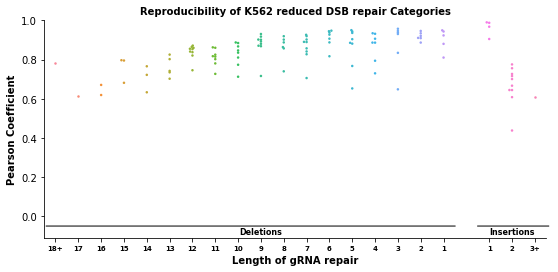

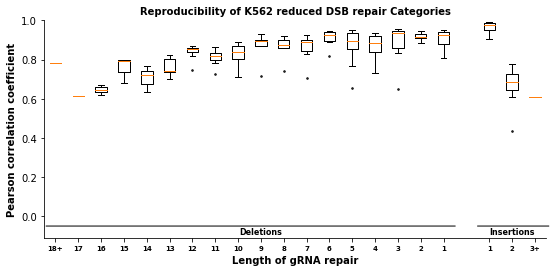

Finish.


In [5]:
## For Reduced DSB repair categories
###########################################
## parameter
main_path = "../../data"
os.chdir(main_path)

figsuplix = 'pdf'
cell_line = 'K562'
read_stat_data_path = './DSB/Integrated_%s_DSB_Repair_Merged_Information.xlsx'%(cell_line)
save_dir = './%s/DSB/Fig36-39-reproducibility'%figsuplix
stat_data = pd.read_excel(read_stat_data_path)


## plot 
delt_name_list = ['D-18+', 'D-17', 'D-16', 'D-15', 'D-14', 'D-13', 'D-12', 'D-11', 
                  'D-10', 'D-9', 'D-8', 'D-7', 'D-6', 'D-5', 'D-4', 'D-3', 'D-2', 'D-1'] 
inser_name_list = ['I-1','I-2','I-3+'] 
## for raw: corr plot data  
stat_data['length_category'] = stat_data['new category'].apply(lambda x: get_DSB_repair_length_category(x))
data_list = get_plot_data(stat_data, delt_name_list, inser_name_list, comp_col='Apearson')
## boxplot  
title = 'Reproducibility of %s reduced DSB repair Categories'%(cell_line)
mkdir(save_dir)
savefig_swarm_path = save_dir + '/Reduced_%s_initally-swarm.%s'%(title, figsuplix)
savefig_box_path = save_dir + '/Reduced_%s_initally-box.%s'%(title, figsuplix)
corr_swarmplot(data_list, delt_name_list, inser_name_list, title, savefig_swarm_path)
corr_boxplot(data_list, delt_name_list, inser_name_list, title, savefig_box_path)
print("Finish.")

stat_data.shape: (163, 2)
(163, 2)
2


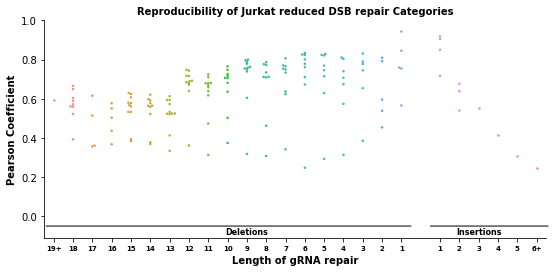

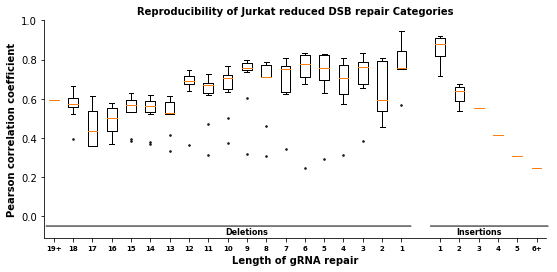

Finish.


In [6]:
## For Reduced DSB repair categories
###########################################
## parameter
cell_line = 'Jurkat'
read_stat_data_path = './DSB/Integrated_%s_DSB_Repair_Merged_Information.xlsx'%(cell_line)
save_dir = './%s/DSB/Fig36-39-reproducibility'%figsuplix
stat_data = pd.read_excel(read_stat_data_path)


## plot
delt_name_list = ['D-19+', 'D-18', 'D-17', 'D-16', 'D-15', 'D-14', 'D-13', 'D-12', 'D-11', 
                  'D-10', 'D-9', 'D-8', 'D-7', 'D-6', 'D-5', 'D-4', 'D-3', 'D-2', 'D-1'] 
inser_name_list = ['I-1', 'I-2', 'I-3', 'I-4', 'I-5', 'I-6+'] 
## for raw: corr plot data 
stat_data['length_category'] = stat_data['new category'].apply(lambda x: get_DSB_repair_length_category(x))
data_list = get_plot_data(stat_data, delt_name_list, inser_name_list, comp_col='Apearson')
## boxplot 
title = 'Reproducibility of %s reduced DSB repair Categories'%(cell_line)
mkdir(save_dir)
savefig_swarm_path = save_dir + '/Reduced_%s_initally-swarm.%s'%(title, figsuplix)
savefig_box_path = save_dir + '/Reduced_%s_initally-box.%s'%(title, figsuplix)
corr_swarmplot(data_list, delt_name_list, inser_name_list, title, savefig_swarm_path)
corr_boxplot(data_list, delt_name_list, inser_name_list, title, savefig_box_path)
print("Finish.")

### Metrics: correlation & symmetricKL

In [7]:
import pandas as pd
import numpy as np
import os
import warnings
warnings.filterwarnings('ignore')

In [8]:
## 基础功能 1：删除文件和创建文件夹
##########################################################################
# 检查文件是否存在，存在删除
def is_Exist_file(path):
    import os
    if os.path.exists(path):
        os.remove(path)


def mkdir(path):
    import os
    path = path.strip()  # 去除首位空格
    path = path.rstrip("\\")  # 去除尾部 \ 符号
    isExists = os.path.exists(path)  # 判断路径是否存在
    # 判断结果
    if not isExists:
        os.makedirs(path)  # 如果不存在则创建目录
        print(path + ' 创建成功')
#     else:
#         print(path + ' 目录已存在')  # 如果目录存在则不创建，并提示目录已存在
##########################################################################

In [9]:
## 基础功能 2： Get Classes of DSB Repair Map
##########################################################################
# 生成n个核苷酸随机组合序列
def single_cycle(c_list, base_list):
    to_list = []
    if len(base_list) == 0:
        to_list = c_list
    else:
        for c in c_list:
            to_list = to_list + [x + c for x in base_list]
    return to_list


def cycle_list(n, c_list):
    to_list = []
    for i in range(n):
        to_list = single_cycle(c_list, to_list)
    return to_list


## Classes of DSB Repair Map
## Insertion Classes
def insertion_classes_2nd():
    c_list = ['A', 'G', 'C', 'T']
    inser_classes = []
    ## insertion 1-2 bp
    for n in range(1,3):
        for nucles in cycle_list(n, c_list):
            one_class = 'I-%s_%s'%(n, nucles)
            inser_classes.append(one_class)
    ## insertion 3+ bp
    one_class = 'I-3+'
    inser_classes.append(one_class)
    return inser_classes


## Deletion Classes
def deletion_classes(edit_sites, max_len=30):
    min_site = min(edit_sites)
    max_site = max(edit_sites)
    delt_classes = []
    for i in range(1, max_len):
        inf_site = min_site - i + 1
        for site in range(inf_site, max_site + 1):
            key = '%s:%sD-%s'%(site, site + i - 1, i)
            delt_classes.append(key)
    delt_classes.append('D30+')
    return delt_classes
##########################################################################

In [10]:
## 4.1 Some Evaluation Functions
##############################################################################
## 评估 top n categories 预测个数
## Evaluation: Prediction Number among Top n categoories
def Evaluation_Topn_Prediction_number(ytrue, ypred, topn):
    ## reset index
    ytrue.reset_index(drop=True, inplace=True)
    ypred.reset_index(drop=True, inplace=True)
    
    ## statistics
    all_index = ytrue.index.tolist()
    record_common_n_dict = {"Index": [], 'Topn_True_Categories': [], "Topn_pred_num": []}
    for index in all_index:
        temp_ture = ytrue.loc[index, :]
        temp_pred = ypred.loc[index, :]
        temp_ture.sort_values(ascending=False, inplace=True)
        temp_pred.sort_values(ascending=False, inplace=True)

        ture_topn_categories = temp_ture.index.tolist()[:topn]
        pred_topn_categories = temp_pred.index.tolist()[:topn]
        ## common number among topn categories
        topn_ture_categories = list(set(ture_topn_categories) & set(pred_topn_categories))
        common_n = len(topn_ture_categories)
        record_common_n_dict['Index'].append(index)
        record_common_n_dict['Topn_True_Categories'].append(str(topn_ture_categories))
        record_common_n_dict['Topn_pred_num'].append(common_n)
    ## DataFrame
    Rdata = pd.DataFrame(record_common_n_dict)
    return Rdata


## 计算 KL Divergence (Kullback-Leibler)
def asymmetricKL(P, Q):
    """
    Epsilon is used here to avoid conditional code for
    checking that neither P nor Q is equal to 0.
    """
    epsilon = 0.00001
    # You may want to instead make copies to avoid changing the np arrays.
    P = P + epsilon
    Q = Q + epsilon
    P_sum = sum(P)
    Q_sum = sum(Q)
    P = P / P_sum
    Q = Q / Q_sum
    divergence = np.sum(P * np.log(P / Q))
    return divergence


def symmetricalKL(P, Q):
    '''
    P = np.asarray([1.346112,1.337432,1.246655])
    Q = np.asarray([1.033836,1.082015,1.117323])
    print(asymmetricKL(P, Q), asymmetricKL(Q, P))
    print(symmetricalKL(P, Q))
    '''
    return (asymmetricKL(P, Q) + asymmetricKL(Q, P)) / 2.00


## Evaluation
## Metrics: pearson & symmetricKL
def evaluation_repair_map(y_train, Y_pred):
    import numpy as np
    from sklearn.metrics import mean_squared_error
    evaluation_dict = {'pearson': [],
                       'spearman': [], 
                       'symKL': [], 
                       'MSE': []}
    sample_n = y_train.shape[0]
    for index in range(sample_n):
        temp_train = y_train[index, :]
        temp_pred = Y_pred[index, :]
        ## pearson
        pccs = np.corrcoef(temp_train, temp_pred)[0, 1]
        evaluation_dict['pearson'].append(pccs)
        ## spearman
        spear = pd.Series(temp_train).corr(pd.Series(temp_pred), method='spearman')
        evaluation_dict['spearman'].append(spear)
        ## symmetricKL
        symKL = symmetricalKL(temp_train, temp_pred)
        evaluation_dict['symKL'].append(symKL)
        ## MSE
        mse = mean_squared_error(temp_train, temp_pred)
        evaluation_dict['MSE'].append(mse)
    ## DataFrame
    eval_df = pd.DataFrame(evaluation_dict)
    return eval_df
# ------------------------------------------------------


def dsb_evaluation(ydata, ypred, topn):
    ## evaluation
    Rdata = Evaluation_Topn_Prediction_number(ydata, ypred, topn)
    result = evaluation_repair_map(np.array(ydata), np.array(ypred))
    ## summary
    result['Top%s_True_Categories'%(topn)] = Rdata['Topn_True_Categories']
    result['Top%s_pred_num'%(topn)] = Rdata['Topn_pred_num']
    return result
##############################################################################